In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D

import yfinance as yf

In [2]:
def calculate_bollinger_bands(data, window=10, num_of_std=2):
    """Calculate Bollinger Bands"""
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    return upper_band, lower_band

def calculate_rsi(data, window=10):
    """Calculate Relative Strength Index"""
    delta = data.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_roc(data, periods=10):
    """Calculate Rate of Change."""
    roc = ((data - data.shift(periods)) / data.shift(periods)) * 100
    return roc

In [3]:
tickers = ['RELIANCE','BHARTIARTL','TATAMOTORS','ZOMATO','SBIN','YESBANK']

In [4]:
ticker_data_frames = []
stats = {}
for ticker in tickers:

    # Download historical data for the ticker
    trade_name = ticker + '.NS'
    data = yf.download(trade_name, period="1y", interval="60m")

    # Calculate the daily percentage change
    close = data['Close']
    upper, lower = calculate_bollinger_bands(close, window=14, num_of_std=2)
    width = upper - lower
    rsi = calculate_rsi(close, window=14)
    roc = calculate_roc(close, periods=14)
    volume = data['Volume']
    diff = data['Close'].diff(1)
    percent_change_close = data['Close'].pct_change() * 100

    # Create a DataFrame for the current ticker and append it to the list
    ticker_df = pd.DataFrame({
        ticker+'_close': close,
        ticker+'_width': width,
        ticker+'_rsi': rsi,
        ticker+'_roc': roc,
        ticker+'_volume': volume,
        ticker+'_diff': diff,
        ticker+'_percent_change_close': percent_change_close,
    })

    MEAN = ticker_df.mean()
    STD = ticker_df.std()

    # Keep track of mean and std
    for column in MEAN.index:
      stats[f"{column}_mean"] = MEAN[column]
      stats[f"{column}_std"] = STD[column]

    # Normalize the training features
    ticker_df = (ticker_df - MEAN) / STD

    ticker_data_frames.append(ticker_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
# Convert stats from dict to df
stats = pd.DataFrame([stats], index=[0])
stats.head()

,RELIANCE_close_mean,RELIANCE_close_std,RELIANCE_width_mean,RELIANCE_width_std,RELIANCE_rsi_mean,RELIANCE_rsi_std,RELIANCE_roc_mean,RELIANCE_roc_std,RELIANCE_volume_mean,RELIANCE_volume_std,...,YESBANK_rsi_mean,YESBANK_rsi_std,YESBANK_roc_mean,YESBANK_roc_std,YESBANK_volume_mean,YESBANK_volume_std,YESBANK_diff_mean,YESBANK_diff_std,YESBANK_percent_change_close_mean,YESBANK_percent_change_close_std
0,2807.702886,244.581711,71.215294,51.500767,51.32887,19.075825,0.14724,1.814604,710973.766181,694260.582944,...,48.819511,19.800221,0.269789,4.152016,2.497949e+07,3.627979e+07,0.002538,0.233071,0.017877,0.969052


In [6]:
# Concatenate all ticker DataFrames
df = pd.concat(ticker_data_frames, axis=1)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.head()

,RELIANCE_close,RELIANCE_width,RELIANCE_rsi,RELIANCE_roc,RELIANCE_volume,RELIANCE_diff,RELIANCE_percent_change_close,BHARTIARTL_close,BHARTIARTL_width,BHARTIARTL_rsi,...,SBIN_volume,SBIN_diff,SBIN_percent_change_close,YESBANK_close,YESBANK_width,YESBANK_rsi,YESBANK_roc,YESBANK_volume,YESBANK_diff,YESBANK_percent_change_close
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-10-16 09:15:00,-1.871370,-0.803834,-0.372193,-0.227318,-1.024073,0.369148,0.449966,-1.369363,-1.118295,0.229221,...,-0.967593,-0.124395,-0.163941,-2.201276,-1.009118,0.059620,-0.064978,-0.688524,0.203643,0.284179
2023-10-16 10:15:00,-1.887929,-0.835737,-0.499660,-0.301078,-0.501425,-0.327263,-0.399270,-1.356704,-1.045290,0.304817,...,-0.248224,0.310924,0.420273,-2.201276,-1.027493,-0.571689,-0.205006,-0.335058,-0.010889,-0.018448
2023-10-16 11:15:00,-1.883227,-0.864104,-0.390428,-0.245008,-0.302376,0.070697,0.085627,-1.362597,-1.030456,0.419816,...,-0.185876,0.017089,0.025710,-2.183022,-1.051035,-0.220968,-0.134993,-0.559397,0.203635,0.283283
2023-10-16 12:15:00,-1.877094,-0.873178,-0.182800,-0.137396,-0.508738,0.097470,0.118224,-1.371327,-1.034655,0.084216,...,-0.572506,-0.254985,-0.338401,-2.201276,-1.055273,-0.220958,-0.135194,-0.561283,-0.225413,-0.319299
2023-10-16 13:15:00,-1.876481,-0.893476,-0.266431,-0.176004,-0.588032,-0.005850,-0.007783,-1.377874,-1.054734,0.011282,...,-0.308488,-0.146156,-0.193057,-2.201276,-1.061478,-0.220958,-0.135194,-0.463928,-0.010889,-0.018448


In [11]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.3 MB/s eta 0:00:00


In [18]:
plotter_data_frames = []

for ticker in tickers:

    # Download historical data for the ticker
    trade_name = ticker + '.NS'
    data = yf.download(trade_name, period="1y", interval="60m")

    # Calculate the daily percentage change
    close = data['Close']
    open = data['Open']
    upper, lower = calculate_bollinger_bands(close, window=10, num_of_std=2)
    rsi = calculate_rsi(close, window=14)
    roc = calculate_roc(close, periods=14)
    volume = data['Volume']
    diff = data['Close'].diff(1)
    percent_change_close = data['Close'].pct_change() * 100

    # Create a DataFrame for the current ticker and append it to the list
    ticker_df = pd.DataFrame({
        ticker+"_open": open,
        ticker+'_close': close,
        ticker+"_lower": lower,
        ticker+"_upper": upper,
        ticker+'_rsi': rsi,
        ticker+'_roc': roc,
        ticker+'_volume': volume,
        ticker+'_diff': diff,
        ticker+'_percent_change_close': percent_change_close,
    })

    plotter_data_frames.append(ticker_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [30]:
plotter_data_frames = []

for ticker in tickers:

    # Download historical data for the ticker
    trade_name = ticker + '.NS'
    name=ticker+"_df"
    name = yf.download(trade_name, period="1y", interval="60m")
    plotter_data_frames.append(name)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [40]:
plot = pd.concat(plotter_data_frames, axis=1)
#df.replace([np.inf, -np.inf], np.nan, inplace=True)
#df.dropna(inplace=True)
plot.head()

,Open,High,Low,Close,Adj Close,Volume,Open,High,Low,Close,...,Low,Close,Adj Close,Volume,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-10-12 09:15:00,2343.850098,2356.350098,2338.699951,2356.250000,2356.250000,1521092,955.000000,956.450012,948.500000,949.400024,...,590.700012,591.500000,591.500000,0,17.150000,17.250000,17.049999,17.100000,17.100000,0
2023-10-12 10:15:00,2356.300049,2359.300049,2351.350098,2355.350098,2355.350098,957985,949.299988,953.000000,948.400024,951.400024,...,589.650024,591.000000,591.000000,843240,17.150000,17.200001,17.100000,17.200001,17.200001,5382400
2023-10-12 11:15:00,2355.300049,2358.000000,2352.399902,2354.100098,2354.100098,720881,951.400024,951.500000,948.400024,949.150024,...,590.250000,590.599976,590.599976,542651,17.200001,17.200001,17.100000,17.200001,17.200001,5303443
2023-10-12 12:15:00,2354.250000,2354.949951,2345.800049,2351.000000,2351.000000,742175,949.000000,953.650024,947.799988,950.200012,...,587.000000,587.900024,587.900024,1711441,17.150000,17.200001,17.100000,17.150000,17.150000,2945535
2023-10-12 13:15:00,2351.100098,2355.000000,2350.750000,2352.800049,2352.800049,835488,950.349976,951.099976,948.299988,949.349976,...,587.000000,587.400024,587.400024,2033099,17.150000,17.150000,17.100000,17.150000,17.150000,1877557


In [46]:
#plot["Datetime"]=plot["Datatime"].dt.strftime("%Y-%m-%d %H:%M:%S")
plot=plot.iloc[:,-7:-1]
plot["Datatime"]=plot.index
plot.head()

,Open,High,Low,Close,Adj Close,Datatime
Datetime,,,,,,
2023-10-12 09:15:00,17.150000,17.250000,17.049999,17.100000,17.100000,2023-10-12 09:15:00
2023-10-12 10:15:00,17.150000,17.200001,17.100000,17.200001,17.200001,2023-10-12 10:15:00
2023-10-12 11:15:00,17.200001,17.200001,17.100000,17.200001,17.200001,2023-10-12 11:15:00
2023-10-12 12:15:00,17.150000,17.200001,17.100000,17.150000,17.150000,2023-10-12 12:15:00
2023-10-12 13:15:00,17.150000,17.150000,17.100000,17.150000,17.150000,2023-10-12 13:15:00


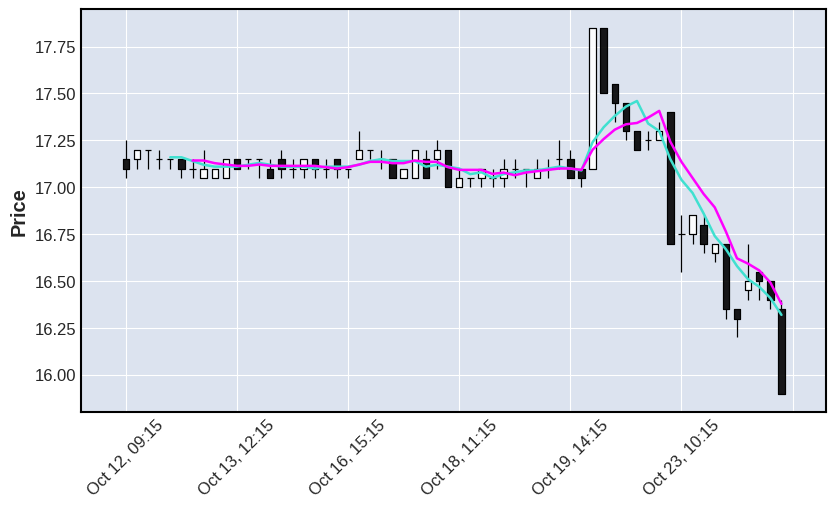

In [48]:
import mplfinance as mpf
plot["Datetime"] = plot.index
Fdf = plot.copy()
Fdf.set_index('Datetime', inplace=True)
#Fdf
#mpf.plot(Fdf.iloc[:60,:], type='candle', mav=(5,7), figratio=(9,5))
mpf.plot(Fdf.iloc[:60,:],
         type='candle',
         mav=(5,7),
         figratio=(9,5),
 #        columns=['RELIANCE_high', 'RELIANCE_low', 'RELIANCE_close', 'RELIANCE_volume']
        )

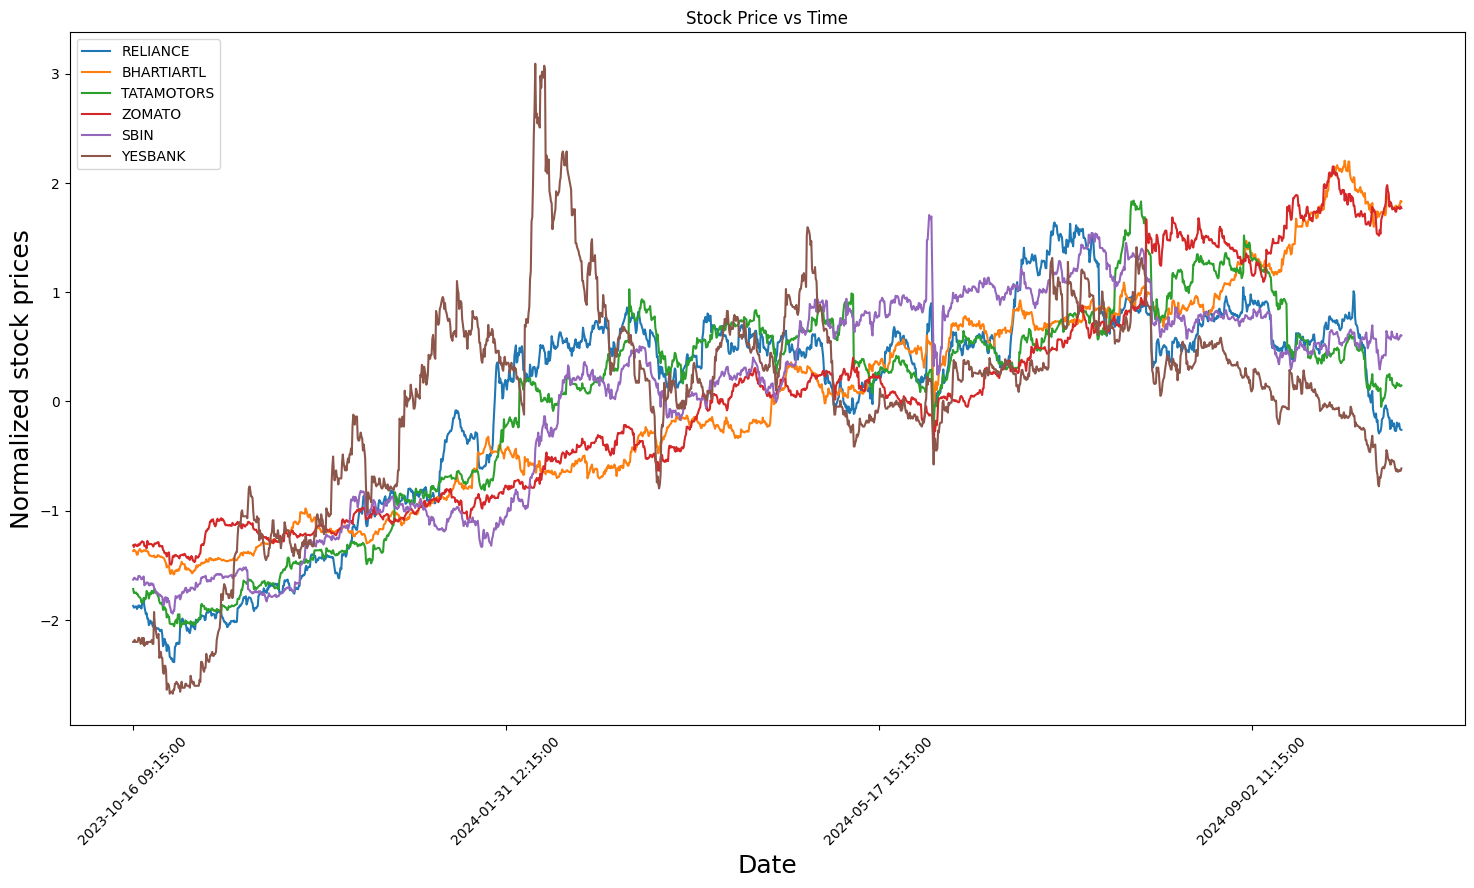

In [9]:
df["Datetime"] = df.index
n = df.shape[0]
p = df.shape[1]
plt.figure(figsize = (18,9))
for ticker in tickers:
  plt.plot(range(df.shape[0]),df[ticker+'_close'])
plt.legend(tickers)
plt.xticks(range(0,df.shape[0],500),df['Datetime'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Normalized stock prices',fontsize=18)
plt.title("Stock Price vs Time")
plt.show()

In [30]:
# Shift the df data to create labels
labels = df.shift(-1)

# Drop the last row in both percent_change_data and labels as it won't have a corresponding label
df = df.iloc[:-1]
labels = labels.iloc[:-1]

In [31]:
df

,RELIANCE_close,RELIANCE_width,RELIANCE_rsi,RELIANCE_roc,RELIANCE_volume,RELIANCE_diff,RELIANCE_percent_change_close,BHARTIARTL_close,BHARTIARTL_width,BHARTIARTL_rsi,...,SBIN_diff,SBIN_percent_change_close,YESBANK_close,YESBANK_width,YESBANK_rsi,YESBANK_roc,YESBANK_volume,YESBANK_diff,YESBANK_percent_change_close,Datetime
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-10-16 09:15:00,-1.871370,-0.803834,-0.372193,-0.227318,-1.024073,0.369148,0.449966,-1.369363,-1.118295,0.229221,...,-0.124395,-0.163941,-2.201276,-1.009118,0.059620,-0.064978,-0.688524,0.203643,0.284179,2023-10-16 09:15:00
2023-10-16 10:15:00,-1.887929,-0.835737,-0.499660,-0.301078,-0.501425,-0.327263,-0.399270,-1.356704,-1.045290,0.304817,...,0.310924,0.420273,-2.201276,-1.027493,-0.571689,-0.205006,-0.335058,-0.010889,-0.018448,2023-10-16 10:15:00
2023-10-16 11:15:00,-1.883227,-0.864104,-0.390428,-0.245008,-0.302376,0.070697,0.085627,-1.362597,-1.030456,0.419816,...,0.017089,0.025710,-2.183022,-1.051035,-0.220968,-0.134993,-0.559397,0.203635,0.283283,2023-10-16 11:15:00
2023-10-16 12:15:00,-1.877094,-0.873178,-0.182800,-0.137396,-0.508738,0.097470,0.118224,-1.371327,-1.034655,0.084216,...,-0.254985,-0.338401,-2.201276,-1.055273,-0.220958,-0.135194,-0.561283,-0.225413,-0.319299,2023-10-16 12:15:00
2023-10-16 13:15:00,-1.876481,-0.893476,-0.266431,-0.176004,-0.588032,-0.005850,-0.007783,-1.377874,-1.054734,0.011282,...,-0.146156,-0.193057,-2.201276,-1.061478,-0.220958,-0.135194,-0.463928,-0.010889,-0.018448,2023-10-16 13:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-11 10:15:00,-0.227543,-0.470574,-0.859474,-0.843393,-0.280622,-0.652507,-0.680404,1.772290,-0.272683,-1.508706,...,-1.005914,-0.976769,-0.642305,-0.728069,-1.383357,-0.594069,-0.551164,-0.268319,-0.307368,2024-10-11 10:15:00
2024-10-11 11:15:00,-0.206692,-0.603865,-0.512162,-0.482937,-0.277636,0.372960,0.384149,1.782111,-0.456851,-1.097586,...,-0.265879,-0.264684,-0.642305,-0.723942,-1.185198,-0.453081,-0.558859,-0.010889,-0.018448,2024-10-11 11:15:00
2024-10-11 12:15:00,-0.201376,-0.695469,-0.369218,-0.343595,-0.641508,0.082169,0.081520,1.796515,-0.874494,-1.087439,...,0.191214,0.178730,-0.627702,-0.728252,-0.855313,-0.342963,-0.592615,0.160728,0.174703,2024-10-11 12:15:00


In [32]:
labels

,RELIANCE_close,RELIANCE_width,RELIANCE_rsi,RELIANCE_roc,RELIANCE_volume,RELIANCE_diff,RELIANCE_percent_change_close,BHARTIARTL_close,BHARTIARTL_width,BHARTIARTL_rsi,...,SBIN_diff,SBIN_percent_change_close,YESBANK_close,YESBANK_width,YESBANK_rsi,YESBANK_roc,YESBANK_volume,YESBANK_diff,YESBANK_percent_change_close,Datetime
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-10-16 09:15:00,-1.887929,-0.835737,-0.499660,-0.301078,-0.501425,-0.327263,-0.399270,-1.356704,-1.045290,0.304817,...,0.310924,0.420273,-2.201276,-1.027493,-0.571689,-0.205006,-0.335058,-0.010889,-0.018448,2023-10-16 10:15:00
2023-10-16 10:15:00,-1.883227,-0.864104,-0.390428,-0.245008,-0.302376,0.070697,0.085627,-1.362597,-1.030456,0.419816,...,0.017089,0.025710,-2.183022,-1.051035,-0.220968,-0.134993,-0.559397,0.203635,0.283283,2023-10-16 11:15:00
2023-10-16 11:15:00,-1.877094,-0.873178,-0.182800,-0.137396,-0.508738,0.097470,0.118224,-1.371327,-1.034655,0.084216,...,-0.254985,-0.338401,-2.201276,-1.055273,-0.220958,-0.135194,-0.561283,-0.225413,-0.319299,2023-10-16 12:15:00
2023-10-16 12:15:00,-1.876481,-0.893476,-0.266431,-0.176004,-0.588032,-0.005850,-0.007783,-1.377874,-1.054734,0.011282,...,-0.146156,-0.193057,-2.201276,-1.061478,-0.220958,-0.135194,-0.463928,-0.010889,-0.018448,2023-10-16 13:15:00
2023-10-16 13:15:00,-1.900195,-0.900028,-0.363492,-0.228927,-0.343650,-0.461187,-0.562675,-1.403191,-1.001829,-0.471049,...,-0.004685,-0.003368,-2.201276,-1.061478,0.059620,-0.064978,-0.265977,-0.010889,-0.018448,2023-10-16 14:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-11 10:15:00,-0.206692,-0.603865,-0.512162,-0.482937,-0.277636,0.372960,0.384149,1.782111,-0.456851,-1.097586,...,-0.265879,-0.264684,-0.642305,-0.723942,-1.185198,-0.453081,-0.558859,-0.010889,-0.018448,2024-10-11 11:15:00
2024-10-11 11:15:00,-0.201376,-0.695469,-0.369218,-0.343595,-0.641508,0.082169,0.081520,1.796515,-0.874494,-1.087439,...,0.191214,0.178730,-0.627702,-0.728252,-0.855313,-0.342963,-0.592615,0.160728,0.174703,2024-10-11 12:15:00
2024-10-11 12:15:00,-0.248191,-0.805415,-0.567738,-0.558443,-0.371582,-0.893562,-0.930986,1.804590,-0.970205,-0.492348,...,0.310924,0.294531,-0.635004,-0.738965,-0.900674,-0.365203,-0.444291,-0.096702,-0.114848,2024-10-11 13:15:00


In [33]:
stats

,RELIANCE_close_mean,RELIANCE_close_std,RELIANCE_width_mean,RELIANCE_width_std,RELIANCE_rsi_mean,RELIANCE_rsi_std,RELIANCE_roc_mean,RELIANCE_roc_std,RELIANCE_volume_mean,RELIANCE_volume_std,...,YESBANK_rsi_mean,YESBANK_rsi_std,YESBANK_roc_mean,YESBANK_roc_std,YESBANK_volume_mean,YESBANK_volume_std,YESBANK_diff_mean,YESBANK_diff_std,YESBANK_percent_change_close_mean,YESBANK_percent_change_close_std
0,2807.702886,244.581711,71.215294,51.500767,51.32887,19.075825,0.14724,1.814604,710973.766181,694260.582944,...,48.819511,19.800221,0.269789,4.152016,2.497949e+07,3.627979e+07,0.002538,0.233071,0.017877,0.969052


In [34]:
temp=[]
temp.append(data[1:1+10])
temp.append(data[10:10+10])
temp[0]

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-10-12 10:15:00,17.150000,17.200001,17.100000,17.200001,17.200001,5382400
2023-10-12 11:15:00,17.200001,17.200001,17.100000,17.200001,17.200001,5303443
2023-10-12 12:15:00,17.150000,17.200001,17.100000,17.150000,17.150000,2945535
2023-10-12 13:15:00,17.150000,17.150000,17.100000,17.150000,17.150000,1877557
2023-10-12 14:15:00,17.150000,17.150000,17.049999,17.100000,17.100000,9864618
2023-10-12 15:15:00,17.100000,17.150000,17.049999,17.100000,17.100000,9723312
2023-10-13 09:15:00,17.049999,17.200001,17.049999,17.100000,17.100000,0
2023-10-13 10:15:00,17.049999,17.100000,17.049999,17.100000,17.100000,2748223
2023-10-13 11:15:00,17.049999,17.150000,17.049999,17.150000,17.150000,3894633


In [35]:
l=[]
l.append([labels[1:10]])
#l.append([labels[2-1], labels[2 + 12], mean[0], std[0]])
l[0][0]

,RELIANCE_close,RELIANCE_width,RELIANCE_rsi,RELIANCE_roc,RELIANCE_volume,RELIANCE_diff,RELIANCE_percent_change_close,BHARTIARTL_close,BHARTIARTL_width,BHARTIARTL_rsi,...,SBIN_diff,SBIN_percent_change_close,YESBANK_close,YESBANK_width,YESBANK_rsi,YESBANK_roc,YESBANK_volume,YESBANK_diff,YESBANK_percent_change_close,Datetime
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-10-16 10:15:00,-1.883227,-0.864104,-0.390428,-0.245008,-0.302376,0.070697,0.085627,-1.362597,-1.030456,0.419816,...,0.017089,0.025710,-2.183022,-1.051035,-0.220968,-0.134993,-0.559397,0.203635,0.283283,2023-10-16 11:15:00
2023-10-16 11:15:00,-1.877094,-0.873178,-0.182800,-0.137396,-0.508738,0.097470,0.118224,-1.371327,-1.034655,0.084216,...,-0.254985,-0.338401,-2.201276,-1.055273,-0.220958,-0.135194,-0.561283,-0.225413,-0.319299,2023-10-16 12:15:00
2023-10-16 12:15:00,-1.876481,-0.893476,-0.266431,-0.176004,-0.588032,-0.005850,-0.007783,-1.377874,-1.054734,0.011282,...,-0.146156,-0.193057,-2.201276,-1.061478,-0.220958,-0.135194,-0.463928,-0.010889,-0.018448,2023-10-16 13:15:00
2023-10-16 13:15:00,-1.900195,-0.900028,-0.363492,-0.228927,-0.343650,-0.461187,-0.562675,-1.403191,-1.001829,-0.471049,...,-0.004685,-0.003368,-2.201276,-1.061478,0.059620,-0.064978,-0.265977,-0.010889,-0.018448,2023-10-16 14:15:00
2023-10-16 14:15:00,-1.888542,-0.903902,-0.158473,-0.126912,-0.734995,0.200791,0.244694,-1.401881,-0.947803,-0.588241,...,-0.091741,-0.120174,-2.201276,-1.061478,0.059620,-0.064978,-0.447940,-0.010889,-0.018448,2023-10-16 15:15:00
2023-10-16 15:15:00,-1.868099,-0.968477,0.917721,0.342886,-1.024073,0.365318,0.445122,-1.370454,-0.953186,-0.313236,...,0.691829,0.931633,-2.164766,-1.029602,0.564669,0.075869,-0.688524,0.418167,0.585026,2023-10-17 09:15:00
2023-10-17 09:15:00,-1.868508,-1.078998,0.910156,0.340522,0.055925,-0.024982,-0.031091,-1.362815,-0.947998,0.281147,...,0.038850,0.054583,-2.164766,-1.008500,0.564669,0.075869,-0.595299,-0.010889,-0.018448,2023-10-17 10:15:00
2023-10-17 10:15:00,-1.884249,-1.196863,0.500390,0.165346,-0.503592,-0.311943,-0.380503,-1.351030,-0.911634,0.437724,...,-0.189690,-0.250344,-2.183022,-1.008500,0.059620,-0.064978,-0.490898,-0.225421,-0.318436,2023-10-17 11:15:00
2023-10-17 11:15:00,-1.871575,-1.193244,-0.001758,-0.057681,-0.512673,0.219904,0.267562,-1.363907,-0.927333,0.165127,...,-0.124382,-0.163389,-2.219532,-0.992608,-0.169951,-0.135402,-0.408170,-0.439945,-0.620162,2023-10-17 12:15:00


In [ ]:
type(data)

pandas.core.frame.DataFrame

In [36]:
# Sequence len = 24 means that we have 2 hours of 5 min data
#SEQUENCE_LEN = int(24*48/2)
SEQUENCE_LEN = int(24)
 # + 12 because we want to predict the next hour or number os hours about prediction
NUMBER_OF_HOURS = 1

# Function to create X-day sequences for each ticker
def create_sequences(data, labels, mean, std, sequence_length=SEQUENCE_LEN):
    sequences = []
    lab = []
    data_size = len(data)


    hrs=int(12*NUMBER_OF_HOURS)
    for i in range(data_size - (sequence_length + 13)):
      if i == 0:
        continue

      sequences.append(data[i:i + sequence_length])
      lab.append([labels[i-1], labels[i + hrs], mean[0], std[0]])

    for i in range(0, len(lab)):
      last_price_data = sequences[i][-1][0]
      last_price_label = lab[i][0]

      if not last_price_data == last_price_label:
        print(f"ERROR : {last_price_data=} and {last_price_label=} are not equal")

    return np.array(sequences), np.array(lab)

In [37]:
sequences_dict = {}
sequence_labels = {}
for ticker in tickers:

    # Extract close and volume data for the ticker
    close = df[ticker+'_close'].values
    width = df[ticker+'_width'].values
    rsi = df[ticker+'_rsi'].values
    roc = df[ticker+'_roc'].values
    volume = df[ticker+'_volume'].values
    diff = df[ticker+'_diff'].values
    pct_change = df[ticker+'_percent_change_close'].values

    # Combine close and volume data
    ticker_data = np.column_stack((close,
                                   width,
                                   rsi,
                                   roc,
                                   volume,
                                   diff,
                                   pct_change))

    # Generate sequences
    attribute = ticker+"_close"
    ticker_sequences, lab = create_sequences(ticker_data,
                                             labels[attribute].values[SEQUENCE_LEN-1:],
                                             stats[attribute+"_mean"].values,
                                             stats[attribute+"_std"].values)

    sequences_dict[ticker] = ticker_sequences
    sequence_labels[ticker] = lab

In [38]:
sequences_dict['RELIANCE'].shape

(1662, 24, 7)

In [39]:
sequence_labels['RELIANCE'].shape

(1662, 4)

In [40]:
# Combine data and labels from all tickers
all_sequences = []
all_labels = []

for ticker in tickers:
    all_sequences.extend(sequences_dict[ticker])
    all_labels.extend(sequence_labels[ticker])

# Convert to numpy arrays
all_sequences = np.array(all_sequences)
all_labels = np.array(all_labels)

In [41]:
all_sequences.shape

(9972, 24, 7)

In [42]:
all_labels.shape

(9972, 4)

In [43]:
np.random.seed(42)
shuffled_indices = np.random.permutation(len(all_sequences))
all_sequences = all_sequences[shuffled_indices]
all_labels = all_labels[shuffled_indices]

train_size = int(len(all_sequences) * 0.8)

# Split sequences
train_sequences = all_sequences[:train_size]
train_labels    = all_labels[:train_size]

other_sequences = all_sequences[train_size:]
other_labels    = all_labels[train_size:]

shuffled_indices = np.random.permutation(len(other_sequences))
other_sequences = other_sequences[shuffled_indices]
other_labels = other_labels[shuffled_indices]

val_size = int(len(other_sequences) * 0.5)

validation_sequences = other_sequences[:val_size]
validation_labels = other_labels[:val_size]

test_sequences = other_sequences[val_size:]
test_labels = other_labels[val_size:]

In [44]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Add()([x, inputs])

    # Feed Forward Part
    y = LayerNormalization(epsilon=1e-6)(x)
    y = Dense(ff_dim, activation="relu")(y)
    y = Dropout(dropout)(y)
    y = Dense(inputs.shape[-1])(y)
    return Add()([y, x])

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs

    # Create multiple layers of the Transformer block
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Final part of the model
    x = GlobalAveragePooling1D()(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    outputs = Dense(1, activation="linear")(x)

    # Compile model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Model parameters
input_shape = train_sequences.shape[1:]
head_size = 256
num_heads = 16
ff_dim = 1024
num_layers = 12
dropout = 0.20

# Build the model
model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 24, 7)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 24, 7)          │             14 │ input_layer[0][0]      │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 24, 7)          │        126,983 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 24, 7)          │              0 │ multi_head_attention[… │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 24, 7)          │             14 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 24, 1024)       │          8,192 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 24, 1024)       │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 24, 7)          │          7,175 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 24, 7)          │              0 │ dense_1[0][0],         │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 24, 7)          │             14 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 24, 7)          │        126,983 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 24, 7)          │              0 │ multi_head_attention_… │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 24, 7)          │             14 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 24, 1024)       │          8,192 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 24, 1024)       │              0 │ dense_2[0][0]          │
├──────────────────────

 Total params: 1,708,558 (6.52 MB)

 Trainable params: 1,708,558 (6.52 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
def custom_mae_loss(y_true, y_pred):
    y_true_next = tf.cast(y_true[:, 1], tf.float64)
    y_pred_next = tf.cast(y_pred[:, 0], tf.float64)
    abs_error = tf.abs(y_true_next - y_pred_next)

    return tf.reduce_mean(abs_error)

def dir_acc(y_true, y_pred):
    mean, std = tf.cast(y_true[:, 2], tf.float64), tf.cast(y_true[:, 3], tf.float64)

    y_true_prev = (tf.cast(y_true[:, 0], tf.float64) * std) + mean
    y_true_next = (tf.cast(y_true[:, 1], tf.float64) * std) + mean
    y_pred_next = (tf.cast(y_pred[:, 0], tf.float64) * std) + mean

    true_change = y_true_next - y_true_prev
    pred_change = y_pred_next - y_true_prev

    correct_direction = tf.equal(tf.sign(true_change), tf.sign(pred_change))

    return tf.reduce_mean(tf.cast(correct_direction, tf.float64))

In [46]:
# Compile the model
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=custom_mae_loss, metrics=[dir_acc])

In [47]:
from google.colab import drive
drive.mount('/content/drive')
drive_path='/content/drive/MyDrive/industrial_project/'

Mounted at /content/drive


In [48]:
# Define a callback to save the best model
train_path=drive_path+"transformer_train_model.keras"
checkpoint_callback_train = ModelCheckpoint(
    train_path,  # Filepath to save the best model
    monitor="dir_acc",  #"loss",  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode="max",  # Minimize the monitored metric
    verbose=1,  # Display progress
)

# Define a callback to save the best model
val_path=drive_path+"transformer_val_model.keras"
checkpoint_callback_val = ModelCheckpoint(
    val_path,  # Filepath to save the best model
    monitor="val_dir_acc", #"val_loss",  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode="max",  # Minimize the monitored metric
    verbose=1,  # Display progress
)

def get_lr_callback(batch_size=16, mode='cos', epochs=500, plot=False):
    lr_start, lr_max, lr_min = 0.0001, 0.005, 0.00001  # Adjust learning rate boundaries
    lr_ramp_ep = int(0.30 * epochs)  # 30% of epochs for warm-up
    lr_sus_ep = max(0, int(0.10 * epochs) - lr_ramp_ep)  # Optional sustain phase, adjust as needed

    def lrfn(epoch):
        if epoch < lr_ramp_ep:  # Warm-up phase
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:  # Sustain phase at max learning rate
            lr = lr_max
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        else:
            lr = lr_min  # Default to minimum learning rate if mode is not recognized

        return lr

    if plot:  # Plot learning rate curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
model.fit(train_sequences, train_labels,
          validation_data=(validation_sequences, validation_labels),
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=True,
          callbacks=[checkpoint_callback_train, checkpoint_callback_val, get_lr_callback(batch_size=BATCH_SIZE, epochs=EPOCHS)])


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - dir_acc: 0.5174 - loss: 0.3918
Epoch 1: dir_acc improved from -inf to 0.52062, saving model to /content/drive/MyDrive/industrial_project/transformer_train_model.keras

Epoch 1: val_dir_acc improved from -inf to 0.53458, saving model to /content/drive/MyDrive/industrial_project/transformer_val_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 104s 351ms/step - dir_acc: 0.5174 - loss: 0.3910 - val_dir_acc: 0.5346 - val_loss: 0.2207 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00026333333333333336.
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - dir_acc: 0.5317 - loss: 0.2616
Epoch 2: dir_acc improved from 0.52062 to 0.53235, saving model to /content/drive/MyDrive/industrial_project/transformer_train_model.keras

Epoch 2: val_dir_acc did not improve from 0.53458
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 106ms/step - dir_acc: 0.5318 - los

In [ ]:
# Load Weights
model.load_weights(drive_path+"transformer_val_model.keras")

# Make predictions
accuracy = model.evaluate(test_sequences, test_labels)[1]
print(accuracy)

# Calculate additional metrics as needed
from sklearn.metrics import r2_score

predictions = model.predict(test_sequences)
r2 = r2_score(test_labels[:, 1], predictions[:, 0])
print(f"R-squared: {r2}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - dir_acc: 0.7543 - loss: 0.1153
0.7476142048835754
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step
R-squared: 0.9608528713024543
